In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np

from datasets import load_dataset
from transformers import LlamaTokenizer, AutoTokenizer

/home/bhuang/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_or_path = "decapoda-research/llama-7b-hf"
# model_name_or_path = "bigscience/bloom-7b1"
# model_name_or_path = "google/mt5-xxl"

tokenizer_class = LlamaTokenizer if "llama" in model_name_or_path else AutoTokenizer
tokenizer = tokenizer_class.from_pretrained(
    model_name_or_path,
    padding_side="right",
    use_fast=False,
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [3]:
data_manifest_path = "../data/vigogne_data_cleaned.json"
ds = load_dataset("json", data_files=data_manifest_path)["train"]

ds

Found cached dataset json (/home/bhuang/.cache/huggingface/datasets/json/default-0cb49f88e2bdf88c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|██████████| 1/1 [00:00<00:00, 473.61it/s]


Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 51914
})

In [4]:
# French instruct translated by chatgpt
PROMPT_DICT = {
    "prompt_input": (
        "Ci-dessous se trouve une instruction qui décrit une tâche, associée à une entrée qui fournit un contexte supplémentaire. Écrivez une réponse qui complète correctement la demande.\n\n"
        "### Instruction:\n{instruction}\n\n### Entrée:\n{input}\n\n### Réponse:\n"
    ),
    "prompt_no_input": (
        "Ci-dessous se trouve une instruction qui décrit une tâche. Écrivez une réponse qui complète correctement la demande.\n\n"
        "### Instruction:\n{instruction}\n\n### Réponse:\n"
    ),
}

def generate_prompt(data_point):
    # sorry about the formatting disaster gotta move fast
    return PROMPT_DICT["prompt_input"].format_map(data_point) if data_point["input"] else PROMPT_DICT["prompt_no_input"].format_map(data_point)


processed_ds = ds.map(lambda example: {
        "source_length": len(tokenizer(generate_prompt(example))["input_ids"]),
        "target_length": len(tokenizer(example["output"] + tokenizer.eos_token)["input_ids"]),
    }
)

In [5]:
processed_ds = processed_ds.map(lambda example: {"example_length": example["source_length"] + example["target_length"]})

processed_ds

Dataset({
    features: ['instruction', 'input', 'output', 'source_length', 'target_length', 'example_length'],
    num_rows: 51914
})

In [6]:
percentile = 96

source_max_length = np.percentile(processed_ds["source_length"], percentile)
target_max_length = np.percentile(processed_ds["target_length"], percentile)
example_max_length = np.percentile(processed_ds["example_length"], percentile)

print(source_max_length, target_max_length, example_max_length)

139.0 274.0 364.0


In [7]:
def increase_to_multiple_of_n(x, n=8):
    return math.ceil((x / n)) * n

print(increase_to_multiple_of_n(source_max_length), increase_to_multiple_of_n(target_max_length), increase_to_multiple_of_n(example_max_length))

144 280 368


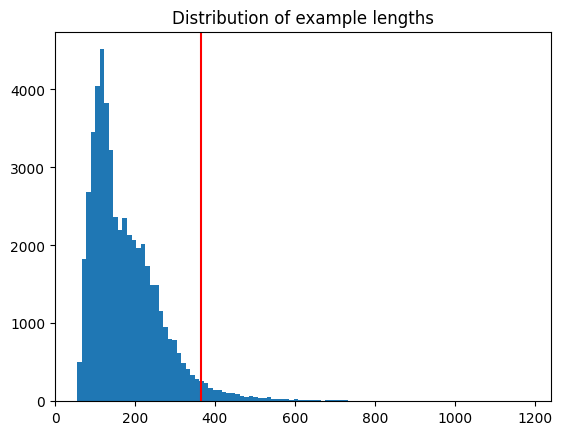

In [8]:
plt.hist(processed_ds["example_length"], bins=100)
plt.title("Distribution of example lengths")
plt.axvline(example_max_length, color="red")

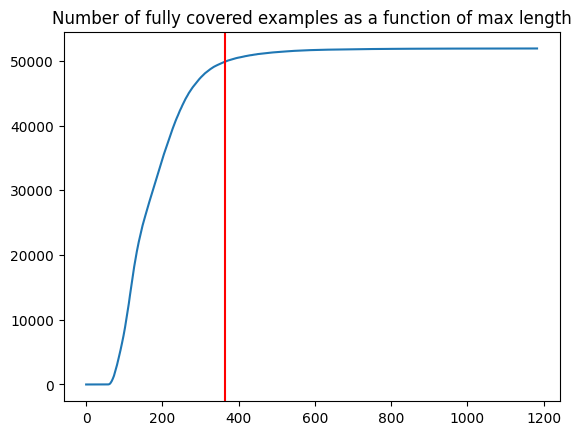

In [9]:
plt.plot([len([l for l in processed_ds["example_length"] if l <= m]) for m in range(max(processed_ds["example_length"]))])
plt.title("Number of fully covered examples as a function of max length")
plt.axvline(x=example_max_length, color="red")

Percentage of tokens left out:

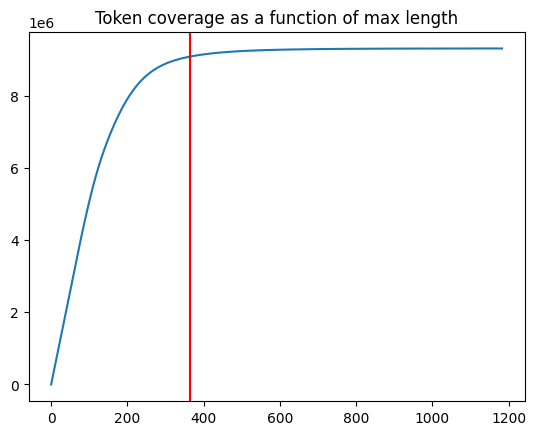

In [10]:
plt.plot([sum(min(l, m) for l in processed_ds["example_length"]) for m in range(max(processed_ds["example_length"]))])
plt.title("Token coverage as a function of max length")
plt.axvline(x=example_max_length, color="red")